In [1]:
import os
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from open_clip import create_model
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import LabelEncoder, StandardScaler
os.chdir('..')

/home/raffaele/art/contrastive-artwork-classification/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.experiment import CLIPGraphRun
from src.data import ImageDataset
from src.utils import load_ruamel
from src.data import DataDict

In [3]:
num_sampled_artworks = 500
num_neighbors = num_sampled_artworks/20
random_state = 42
save=True

In [ ]:
test_set = pd.read_csv('./data/processed/normal/artgraph_clip_genre/test.csv')
test_set

,artwork,genre
0,konstantin-korovin_morning-1914.jpg,landscape
1,jimmy-ernst_synapse-1950.jpg,abstract
2,nicholas-roerich_lahaul-himalayas-1932.jpg,landscape
3,vilho-lampi_self-portrait-1931.jpg,self-portrait
4,william-holman-hunt_may-morning-on-magdalen-co...,genre painting
...,...,...
11642,claude-monet_the-manneport.jpg,landscape
11643,george-romney_miss-martindale-1782.jpg,portrait
11644,jacques-louis-david_portrait-of-madame-charles...,portrait
11645,giovanni-bellini_pesaro-altarpiece-1474-2.jpg,religious painting


In [5]:
drop, sampled_test_set = train_test_split(
    test_set,
    test_size=num_sampled_artworks,
    stratify=test_set["genre"],
    random_state=42,
)
sampled_test_set

,artwork,genre
2865,giovanni-domenico-tiepolo_the-procession-of-th...,mythological painting
8328,ion-andreescu_portrait-of-a-peasant-girl.jpg,portrait
5161,jules-lefranc_links.jpg,landscape
1276,nicholas-roerich_russian-prince-collects-tribu...,genre painting
2391,pyotr-konchalovsky_the-head-of-boy-in-profile-...,portrait
...,...,...
6829,filippo-lippi_vision-of-st-augustine.jpg,religious painting
2257,koloman-moser_laurel-wreath-1897.jpg,design
8938,elenore-abbott_a-folding-screen-entitled-rose-...,design
8256,edouard-riou_hammam-bou-ghrara-i-e-hammam-boug...,illustration


In [6]:
parameters = load_ruamel(
    "./configs_cineca/proposed_model/genre/normal_clip_graph_sage3.yaml"
)
parameters["clean_out_dir"] = False
parameters["model"]["gnn"]["params"]["dropout"] = 0.0
run = CLIPGraphRun(parameters=parameters)
run.load_state_dict()

Loading general parameters...
Done!
Loading dataloaders...


Done!
Loading model...
Done!
Loading metrics...
Done!
Loading tokenizer...
Done!
Loading criterion...
Done!
Loading optimizer...
Done!
Loading scheduler...
Done!
Loading early stop callback...
Done!
loading state dict from models/proposed/genre/normal_clip_graph_gcn3/ParameterKeys.MODEL.pt


In [7]:
visual = run.model.visual
visual

VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
  (patch_dropout): Identity()
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ls_1): Identity()
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ls_2): Identity()
      )
    )
  )
  (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [8]:
sampled_image_test_dataset = ImageDataset(
    dataset=sampled_test_set,
    img_dir=run.test_loader.dataset.img_dir,
    preprocess=run.test_loader.dataset.preprocess,
)
batch_size = 64
sampled_dataloader = DataLoader(
    dataset=sampled_image_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
)

In [9]:
out_features = torch.empty(size=(len(sampled_image_test_dataset), 512))
out_features.size()

torch.Size([500, 512])

In [10]:
clip_model = create_model(**parameters["model"]["visual"]).visual.to("cuda")
clip_features = torch.zeros_like(out_features)

In [11]:
with torch.no_grad():
    for ix, (data_dict) in tqdm(
        enumerate(sampled_dataloader), total=len(sampled_dataloader)
    ):
        img_tensors = data_dict[DataDict.IMAGE].to("cuda")
        img_feats = visual(img_tensors)
        img_clip_feats = clip_model(img_tensors)
        start_idx = ix * batch_size
        end_idx = min((ix + 1) * batch_size, out_features.size(0))
        out_features[start_idx:end_idx] = img_feats.cpu()
        clip_features[start_idx:end_idx] = img_clip_feats.cpu()

out_features = out_features.numpy()
clip_features = clip_features.numpy()

100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


In [12]:
custom_palette = [
    "#1F77B4",
    "#AEC7E8",
    "#FF7F0E",
    "#FFBB78",
    "#2CA02C",
    "#98DF8A",
    "#D62728",
    "#FF9896",
    "#9467BD",
    "#C5B0D5",
    "#8C564B",
    "#C49C94",
    "#E377C2",
    "#F7B6D2",
    "#7F7F7F",
    "#C7C7C7",
    "#BCBD22",
    "#DBDB8D",
]
len(custom_palette)

18

# TNSE

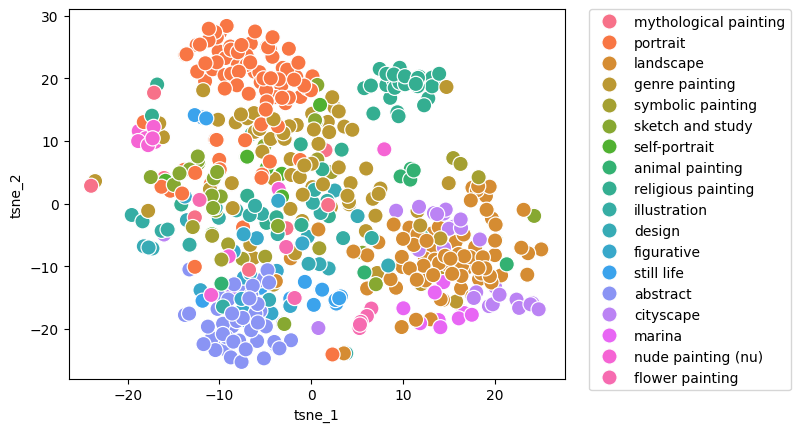

In [13]:
n_components = 2
tsne = TSNE(
    n_components=n_components, perplexity=num_neighbors, random_state=random_state
)
tsne_result = tsne.fit_transform(StandardScaler().fit_transform(out_features))
tsne_result_df = pd.DataFrame(
    {
        "tsne_1": tsne_result[:, 0],
        "tsne_2": tsne_result[:, 1],
        "label": sampled_test_set["genre"].values,
    }
)
fig, ax = plt.subplots(1)
sns.scatterplot(x="tsne_1", y="tsne_2", hue="label", data=tsne_result_df, ax=ax, s=120)
lim = (tsne_result.min() - 5, tsne_result.max() + 5)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
fig.savefig('./reports/figures/graph_clip_tsne_genre.png', dpi=500, bbox_inches="tight")

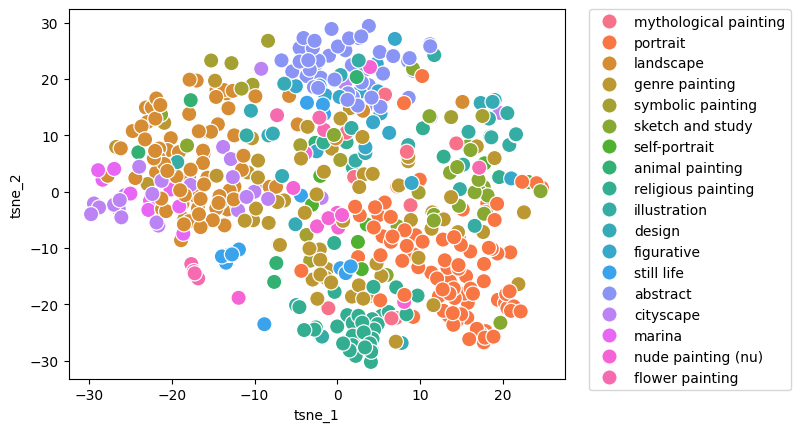

In [15]:
n_components = 2
tsne = TSNE(
    n_components=n_components, perplexity=num_neighbors, random_state=random_state
)
tsne_result = tsne.fit_transform(StandardScaler().fit_transform(clip_features))
tsne_result_df = pd.DataFrame(
    {
        "tsne_1": tsne_result[:, 0],
        "tsne_2": tsne_result[:, 1],
        "label": sampled_test_set["genre"].values,
    }
)
fig, ax = plt.subplots(1)
sns.scatterplot(x="tsne_1", y="tsne_2", hue="label", data=tsne_result_df, ax=ax, s=120)
lim = (tsne_result.min() - 5, tsne_result.max() + 5)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
fig.savefig('./reports/figures/clip_tsne_genre.png', dpi=500, bbox_inches="tight")

# UMAP

/home/raffaele/art/contrastive-artwork-classification/.venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'GRAPH CLIP FEATURES')

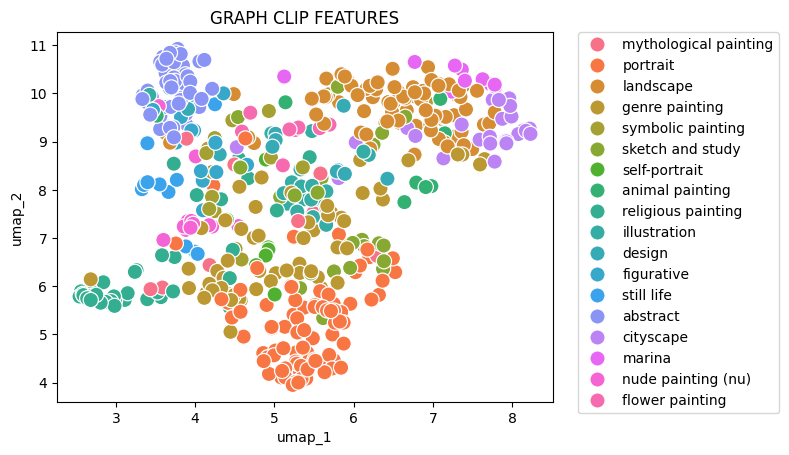

In [15]:
labels = LabelEncoder().fit_transform(sampled_test_set["genre"].values)
reduced = umap.UMAP(n_neighbors=int(num_neighbors), random_state=random_state)

embedding = reduced.fit_transform(StandardScaler().fit_transform(out_features))

umap_result_df = pd.DataFrame(
    {
        "umap_1": embedding[:, 0],
        "umap_2": embedding[:, 1],
        "label": sampled_test_set["genre"].values,
    }
)

fig, ax = plt.subplots(1)
sns.scatterplot(x="umap_1", y="umap_2", hue="label", data=umap_result_df, ax=ax, s=120)
lim = (embedding.min() - 5, embedding.max() + 5)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
ax.set_title("GRAPH CLIP FEATURES")

/home/raffaele/art/contrastive-artwork-classification/.venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'CLIP FEATURES')

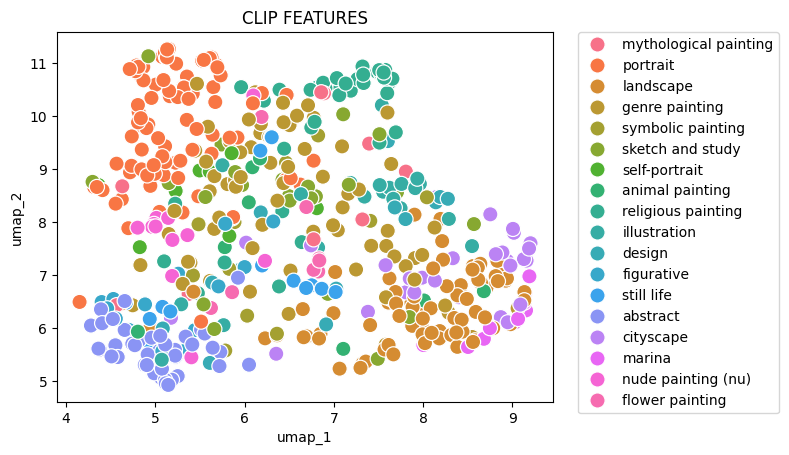

In [16]:
labels = LabelEncoder().fit_transform(sampled_test_set["genre"].values)
reduced = umap.UMAP(n_neighbors=int(num_neighbors), random_state=random_state)

embedding = reduced.fit_transform(StandardScaler().fit_transform(clip_features))

umap_result_df = pd.DataFrame(
    {
        "umap_1": embedding[:, 0],
        "umap_2": embedding[:, 1],
        "label": sampled_test_set["genre"].values,
    }
)

fig, ax = plt.subplots(1)
sns.scatterplot(x="umap_1", y="umap_2", hue="label", data=umap_result_df, ax=ax, s=120)
lim = (embedding.min() - 5, embedding.max() + 5)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
ax.set_title("CLIP FEATURES")

# PCA

Text(0.5, 1.0, 'GRAPH CLIP FEATURES')

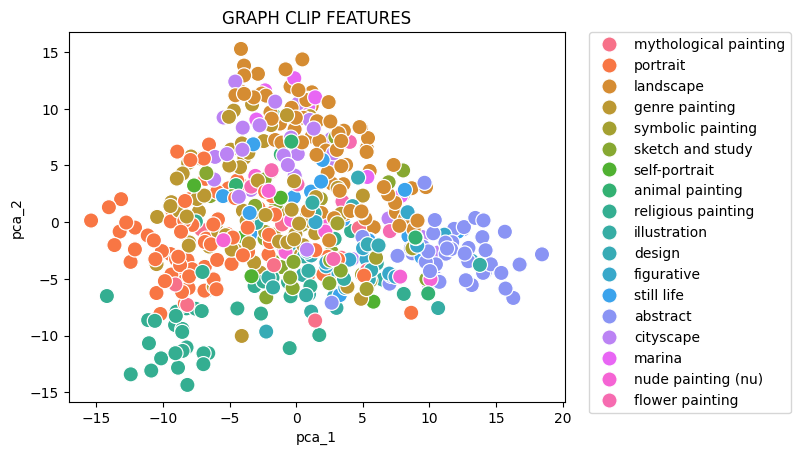

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=n_components)
pca_trans = pca.fit_transform(StandardScaler().fit_transform(out_features))
pca_result_df = pd.DataFrame(
    {
        "pca_1": pca_trans[:, 0],
        "pca_2": pca_trans[:, 1],
        "label": sampled_test_set["genre"].values,
    }
)

fig, ax = plt.subplots(1)
sns.scatterplot(x="pca_1", y="pca_2", hue="label", data=pca_result_df, ax=ax, s=120)
lim = (pca_trans.min() - 5, pca_trans.max() + 5)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
ax.set_title("GRAPH CLIP FEATURES")

Text(0.5, 1.0, 'CLIP FEATURES')

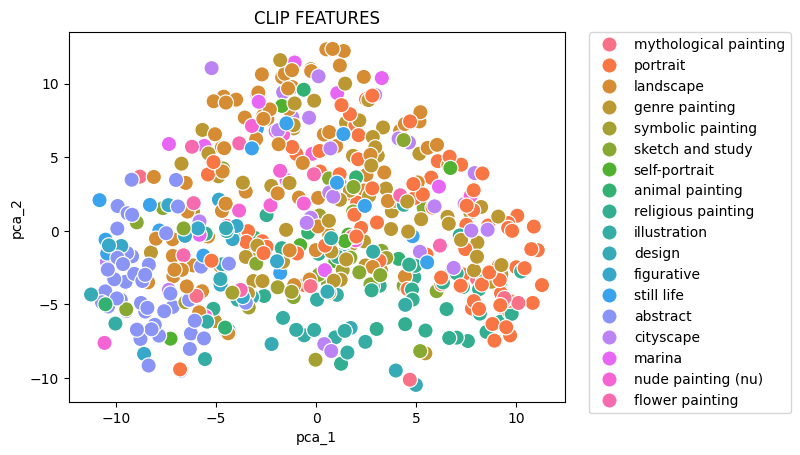

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=n_components)
pca_trans = pca.fit_transform(StandardScaler().fit_transform(clip_features))
pca_result_df = pd.DataFrame(
    {
        "pca_1": pca_trans[:, 0],
        "pca_2": pca_trans[:, 1],
        "label": sampled_test_set["genre"].values,
    }
)

fig, ax = plt.subplots(1)
sns.scatterplot(x="pca_1", y="pca_2", hue="label", data=pca_result_df, ax=ax, s=120)
lim = (pca_trans.min() - 5, pca_trans.max() + 5)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
ax.set_title("CLIP FEATURES")